## Dimitrios Fikos 9/12/2024
##### Principal Components Efficiency

In this script, scree plots are generated for the purpose of identifying the optimal number of principal components, which are then used to discern the fundamental dimensions of a given dataset. This visual tool reveals the amount of variance captured by each principal component in a dimensionality reduction technique. It should be noted that the eigenvalues are simply the squared singular values taken by matrix $S$. The model presented above is expected to have $d=2$ since there is the quadratic component $x_2^2$ and two linear components $x_1$ and $x_3$. Parameters selected are $n=5000$, $p=12$ and $k=\sqrt{n}$.

In [1]:
# libraries 
import math
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

# Work with Model : $$g(x)=X_1 + X_2^2 +X_3$$ 

 In this case
$$ \nabla g (x) = (1, 2X_2,1,0,\ldots, 0) ^T$$

In [2]:
# Generate 100 random X_vectors with N(0,1) 
def random_points(dim):
    rng=np.random.RandomState(1)
    x_specific3 = rng.normal(loc=0, scale=1, size=(100, dim))
    return x_specific3

In [3]:
def data(size,dim):
    rng=np.random.RandomState(1)
    # reproducibility of data
    datasets=[]
    for i in range(100):
        # Random variable X with 'dim' dimensions
        X = rng.normal(loc=0, scale=1, size=(size, dim))
        # Make the errors
        errors = rng.normal(loc=0, scale=0.7, size=size)
        # make the Y 
        Y = X[:,0] + X[:, 1]**2 + X[:,2] + errors
        datasets.append((X, Y))
    return datasets

In [4]:
####### 1) Projection from OLS ########
def b_ols(x_specific3, X, Y, k, dim):
    estimations=[]
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    for x in x_specific3:
        x_spec = np.array([x])  
        distances, indices = knn.kneighbors(x_spec)
        # Get the k-nearest neighbors
        nearest_X = X[indices].reshape(k, -1)
        nearest_Y = Y[indices].flatten()
        sum_xi = sum_yi =0 
        for i in range(len(nearest_X)):
            sum_xi+=nearest_X[i]
            sum_yi+=nearest_Y[i]
        sum_xi, sum_yi = sum_xi/k, sum_yi/k 
        nearest_X, nearest_Y = nearest_X - sum_xi, nearest_Y - sum_yi
        # Initialize the Linear Regression model
        linear_regression = LinearRegression(fit_intercept=False)
        # Fit the model to the data
        linear_regression.fit(nearest_X, nearest_Y)
        # Print the coefficient(s)
        estimated_gradient = linear_regression.coef_
        estimations.append(estimated_gradient)
    estimations=np.array(estimations)
    U, S, Vh =np.linalg.svd(estimations, full_matrices=True, compute_uv=True)
    # Analyze feature contributions from the first two principal components
    feature_contributions_pc1 = np.abs(Vh[0, :])  # First principal component
    feature_contributions_pc2 = np.abs(Vh[1, :])  # Second principal component 
    return S, feature_contributions_pc1, feature_contributions_pc2

####### 2) Projection deriving from OLS + Lasso ########
def b_ols_lasso(x_specific3, X, Y, k, dim):
    estimations=[]
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    for x in x_specific3:
        x_spec = np.array([x])  
        distances, indices = knn.kneighbors(x_spec)
        # Get the k-nearest neighbors
        nearest_X = X[indices].reshape(k, -1)
        nearest_Y = Y[indices].flatten()
        sum_xi = sum_yi =0 
        for i in range(len(nearest_X)):
            sum_xi+=nearest_X[i]
            sum_yi+=nearest_Y[i]
        sum_xi, sum_yi = sum_xi/k, sum_yi/k 
        nearest_X, nearest_Y = nearest_X - sum_xi, nearest_Y - sum_yi
        # Initialize the Linear Regression model with lasso
        lasso_model = LassoCV(alphas=alphas, cv=5, fit_intercept=False, max_iter=10000, tol=1e-4)
        lasso_model.fit(nearest_X, nearest_Y)
        # Print the coefficients
        estimated_gradient = lasso_model.coef_
        estimations.append(estimated_gradient)
    estimations=np.array(estimations)
    U, S, Vh =np.linalg.svd(estimations, full_matrices=True, compute_uv=True)
    # Analyze feature contributions from the first two principal components
    feature_contributions_pc1 = np.abs(Vh[0, :])  # First principal component
    feature_contributions_pc2 = np.abs(Vh[1, :])  # Second principal component 
    return S, feature_contributions_pc1, feature_contributions_pc2

In [15]:
####### 3) Projection deriving from OLS + diagonal ######## 
def b_ols_diag(x_specific3, X, Y, k, dim):
    estimations=[]
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    for x in x_specific3:
        x_spec = np.array([x])  
        distances, indices = knn.kneighbors(x_spec)
        # Get the k-nearest neighbors
        nearest_X = X[indices].reshape(k, -1)
        nearest_Y = Y[indices].flatten()
        b_ols=[]
        for j in range(nearest_X.shape[1]):
            numer=np.cov(nearest_X[:, j],nearest_Y)[0,1] # select value in 0,1 place from the cov. matrix
            denom=np.cov(nearest_X[:, j],nearest_X[:, j])[0,0]
            b_ols.append(numer/denom)
        estimations.append(b_ols)
    estimations=np.array(estimations)
    U, S, Vh =np.linalg.svd(estimations, full_matrices=True, compute_uv=True)
    # Analyze feature contributions from the first two principal components
    feature_contributions_pc1 = np.abs(Vh[0, :])  # First principal component
    feature_contributions_pc2 = np.abs(Vh[1, :])  # Second principal component 
    return S, feature_contributions_pc1, feature_contributions_pc2

####### 4) Projection deriving from OLS + trace ######## 
def b_ols_trace(x_specific3, X, Y, k, dim):
    estimations=[]
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    for x in x_specific3:
        x_spec = np.array([x])  
        distances, indices = knn.kneighbors(x_spec)
        # Get the k-nearest neighbors
        nearest_X = X[indices].reshape(k, -1)
        nearest_Y = Y[indices].flatten()
        b_ols=[]
        denom=0
        for j in range(nearest_X.shape[1]):
            numer=np.cov(nearest_X[:, j],nearest_Y)[0,1] # select value in 0,1 place from the cov.matrix
            b_ols.append(numer)
        estimations.append(b_ols)
    estimations=np.array(estimations)
    U, S, Vh =np.linalg.svd(estimations, full_matrices=True, compute_uv=True)
    # Analyze feature contributions from the first two principal components
    feature_contributions_pc1 = np.abs(Vh[0, :])  # First principal component
    feature_contributions_pc2 = np.abs(Vh[1, :])  # Second principal component 
    return S, feature_contributions_pc1, feature_contributions_pc2

## Case where n=5000 and P=12

In [6]:
x_specific_12=random_points(12)
dataset_5000_12=data(5000,12)
knn_values_5000 = [71] 
alphas = np.logspace(-6, 0, 20)

The procedure here is the following. We are using 100 datasets and we find their principal components. Then the mean value for each of these components is 

## b_ols

Top contributing features for the first principal component:
Feature 0: Influence = 0.6879
Feature 2: Influence = 0.6870
Feature 1: Influence = 0.2086

Top contributing features for the second principal component:
Feature 1: Influence = 0.9721
Feature 2: Influence = 0.1533
Feature 0: Influence = 0.1417


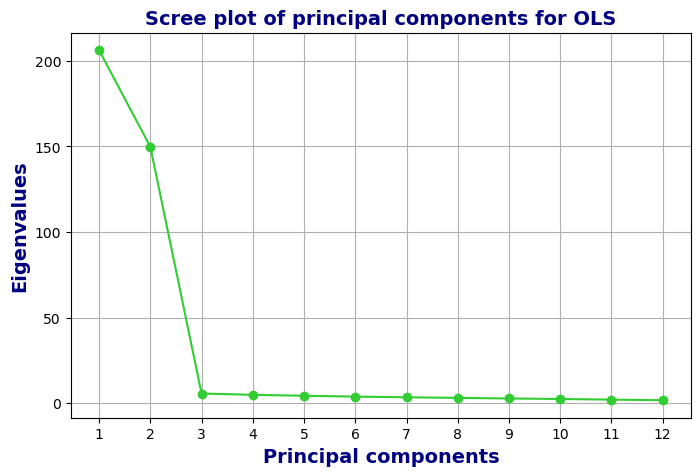

In [8]:
S_values=[]
feature_importances_pc1 = []
feature_importances_pc2 = []
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_12):
    for k in knn_values_5000:
        S, feature_pc1, feature_pc2 = b_ols(x_specific_12, X, Y, k=k, dim=12)
        S_values.append(S)
        feature_importances_pc1.append(feature_pc1)
        feature_importances_pc2.append(feature_pc2)
# Convert the list to a 100x12 array 
S_values = np.array(S_values)
feature_importances_pc1 = np.array(feature_importances_pc1)
feature_importances_pc2 = np.array(feature_importances_pc2)
# Compute the mean value for each singular value (per column)
mean_singular_values = np.mean(S_values, axis=0)
mean_feature_importance_pc1 = np.mean(feature_importances_pc1, axis=0)
mean_feature_importance_pc2 = np.mean(feature_importances_pc2, axis=0)
# Select top features dynamically
num_top_features = 3  # Adjust based on the number of features you want to display
top_features_pc1 = np.argsort(-mean_feature_importance_pc1)[:num_top_features]
top_features_pc2 = np.argsort(-mean_feature_importance_pc2)[:num_top_features]

# Get the influence (weights) of these top features
top_features_pc1_influence = mean_feature_importance_pc1[top_features_pc1]
top_features_pc2_influence = mean_feature_importance_pc2[top_features_pc2]

# Display the results
print("Top contributing features for the first principal component:")
for i, (feature, influence) in enumerate(zip(top_features_pc1, top_features_pc1_influence)):
    print(f"Feature {feature}: Influence = {influence:.4f}")

print("\nTop contributing features for the second principal component:")
for i, (feature, influence) in enumerate(zip(top_features_pc2, top_features_pc2_influence)):
    print(f"Feature {feature}: Influence = {influence:.4f}")
# Compute the mean value for each singular value (per column)
mean_singular_values = np.mean(S_values, axis=0)
# Convert singular values to eigenvalues by squaring them
mean_eigenvalues_ols = mean_singular_values**2
# Create a scree plot for the mean eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mean_eigenvalues_ols) + 1), mean_eigenvalues_ols, marker='o',  linestyle='-', color='#32CD32')
plt.title('Scree plot of principal components for OLS',fontsize=14, fontweight='bold', color='navy')
plt.xlabel('Principal components',fontsize=14, fontweight='bold', color='navy')
plt.ylabel('Eigenvalues',fontsize=14, fontweight='bold', color='navy')
plt.xticks(range(1, len(mean_eigenvalues_ols) + 1))
plt.grid()
#plt.savefig('scree_2_ols.pdf', bbox_inches='tight')
plt.show()

## b_ols_lasso

Top contributing features for the first principal component:
Feature 2: Influence = 0.6659
Feature 0: Influence = 0.6644
Feature 1: Influence = 0.3017

Top contributing features for the second principal component:
Feature 1: Influence = 0.9406
Feature 2: Influence = 0.2184
Feature 0: Influence = 0.2085


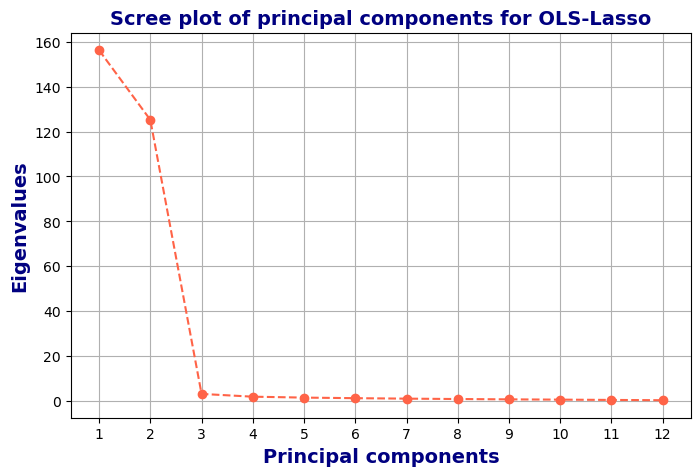

In [9]:
S_values=[]
feature_importances_pc1 = []
feature_importances_pc2 = []
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_12):
    for k in knn_values_5000:
        S, feature_pc1, feature_pc2 = b_ols_lasso(x_specific_12, X, Y, k=k, dim=12)
        S_values.append(S)
        feature_importances_pc1.append(feature_pc1)
        feature_importances_pc2.append(feature_pc2)
# Convert the list to a 100x12 array 
S_values = np.array(S_values)
feature_importances_pc1 = np.array(feature_importances_pc1)
feature_importances_pc2 = np.array(feature_importances_pc2)
# Compute the mean value for each singular value (per column)
mean_singular_values = np.mean(S_values, axis=0)
mean_feature_importance_pc1 = np.mean(feature_importances_pc1, axis=0)
mean_feature_importance_pc2 = np.mean(feature_importances_pc2, axis=0)
# Select top features dynamically
num_top_features = 3  # Adjust based on the number of features you want to display
top_features_pc1 = np.argsort(-mean_feature_importance_pc1)[:num_top_features]
top_features_pc2 = np.argsort(-mean_feature_importance_pc2)[:num_top_features]

# Get the influence (weights) of these top features
top_features_pc1_influence = mean_feature_importance_pc1[top_features_pc1]
top_features_pc2_influence = mean_feature_importance_pc2[top_features_pc2]

# Display the results
print("Top contributing features for the first principal component:")
for i, (feature, influence) in enumerate(zip(top_features_pc1, top_features_pc1_influence)):
    print(f"Feature {feature}: Influence = {influence:.4f}")

print("\nTop contributing features for the second principal component:")
for i, (feature, influence) in enumerate(zip(top_features_pc2, top_features_pc2_influence)):
    print(f"Feature {feature}: Influence = {influence:.4f}")
# Compute the mean value for each singular value (per column)
mean_singular_values = np.mean(S_values, axis=0)
# Convert singular values to eigenvalues by squaring them
mean_eigenvalues_lasso = mean_singular_values**2
# Create a scree plot for the mean eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mean_eigenvalues_lasso) + 1), mean_eigenvalues_lasso, marker='o', linestyle='--', color='#FF6347')
plt.title('Scree plot of principal components for OLS-Lasso',fontsize=14, fontweight='bold', color='navy')
plt.xlabel('Principal components',fontsize=14, fontweight='bold', color='navy')
plt.ylabel('Eigenvalues',fontsize=14, fontweight='bold', color='navy')
plt.xticks(range(1, len(mean_eigenvalues_lasso) + 1))
plt.grid()
#plt.savefig('scree_2_ols_lasso.pdf', bbox_inches='tight')
plt.show()

## b_ols_diag

Top contributing features for the first principal component:
Feature 2: Influence = 0.6891
Feature 0: Influence = 0.6858
Feature 1: Influence = 0.1911

Top contributing features for the second principal component:
Feature 1: Influence = 0.9703
Feature 0: Influence = 0.1455
Feature 2: Influence = 0.1271


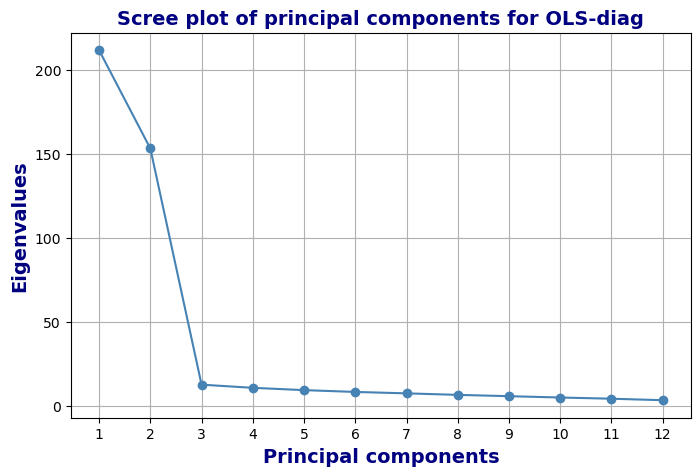

In [10]:
S_values=[]
feature_importances_pc1 = []
feature_importances_pc2 = []
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_12):
    for k in knn_values_5000:
        S, feature_pc1, feature_pc2 = b_ols_diag(x_specific_12, X, Y, k=k, dim=12)
        S_values.append(S)
        feature_importances_pc1.append(feature_pc1)
        feature_importances_pc2.append(feature_pc2)
# Convert the list to a 100x12 array 
S_values = np.array(S_values)
feature_importances_pc1 = np.array(feature_importances_pc1)
feature_importances_pc2 = np.array(feature_importances_pc2)
# Compute the mean value for each singular value (per column)
mean_singular_values = np.mean(S_values, axis=0)
mean_feature_importance_pc1 = np.mean(feature_importances_pc1, axis=0)
mean_feature_importance_pc2 = np.mean(feature_importances_pc2, axis=0)
# Select top features dynamically
num_top_features = 3  # Adjust based on the number of features you want to display
top_features_pc1 = np.argsort(-mean_feature_importance_pc1)[:num_top_features]
top_features_pc2 = np.argsort(-mean_feature_importance_pc2)[:num_top_features]

# Get the influence (weights) of these top features
top_features_pc1_influence = mean_feature_importance_pc1[top_features_pc1]
top_features_pc2_influence = mean_feature_importance_pc2[top_features_pc2]

# Display the results
print("Top contributing features for the first principal component:")
for i, (feature, influence) in enumerate(zip(top_features_pc1, top_features_pc1_influence)):
    print(f"Feature {feature}: Influence = {influence:.4f}")

print("\nTop contributing features for the second principal component:")
for i, (feature, influence) in enumerate(zip(top_features_pc2, top_features_pc2_influence)):
    print(f"Feature {feature}: Influence = {influence:.4f}")
# Compute the mean value for each singular value (per column)
mean_singular_values = np.mean(S_values, axis=0)
# Convert singular values to eigenvalues by squaring them
mean_eigenvalues_diag = mean_singular_values**2
# Create a scree plot for the mean eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mean_eigenvalues_diag) + 1), mean_eigenvalues_diag, marker='o', linestyle='-', color='#4682B4')
plt.title('Scree plot of principal components for OLS-diag',fontsize=14, fontweight='bold', color='navy')
plt.xlabel('Principal components',fontsize=14, fontweight='bold', color='navy')
plt.ylabel('Eigenvalues',fontsize=14, fontweight='bold', color='navy')
plt.xticks(range(1, len(mean_eigenvalues_diag) + 1))
plt.grid()
#plt.savefig('scree_2_ols_diag.pdf', bbox_inches='tight')
plt.show()

## b_ols_trace

Top contributing features for the first principal component:
Feature 2: Influence = 0.6835
Feature 0: Influence = 0.6755
Feature 1: Influence = 0.2295

Top contributing features for the second principal component:
Feature 1: Influence = 0.9580
Feature 0: Influence = 0.1716
Feature 2: Influence = 0.1548


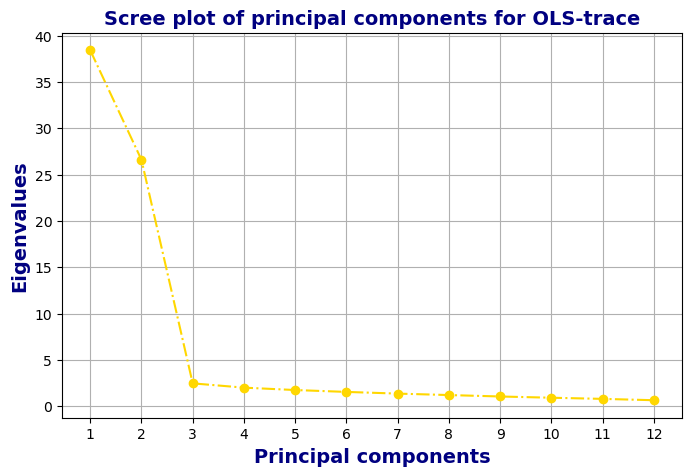

In [16]:
S_values=[]
feature_importances_pc1 = []
feature_importances_pc2 = []
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_12):
    for k in knn_values_5000:
        S, feature_pc1, feature_pc2 = b_ols_trace(x_specific_12, X, Y, k=k, dim=12)
        S_values.append(S)
        feature_importances_pc1.append(feature_pc1)
        feature_importances_pc2.append(feature_pc2)
# Convert the list to a 100x12 array 
S_values = np.array(S_values)
feature_importances_pc1 = np.array(feature_importances_pc1)
feature_importances_pc2 = np.array(feature_importances_pc2)
# Compute the mean value for each singular value (per column)
mean_singular_values = np.mean(S_values, axis=0)
mean_feature_importance_pc1 = np.mean(feature_importances_pc1, axis=0)
mean_feature_importance_pc2 = np.mean(feature_importances_pc2, axis=0)
# Select top features dynamically
num_top_features = 3  
top_features_pc1 = np.argsort(-mean_feature_importance_pc1)[:num_top_features]
top_features_pc2 = np.argsort(-mean_feature_importance_pc2)[:num_top_features]
# Get the influence (weights) of these top features
top_features_pc1_influence = mean_feature_importance_pc1[top_features_pc1]
top_features_pc2_influence = mean_feature_importance_pc2[top_features_pc2]

# Display the results
print("Top contributing features for the first principal component:")
for i, (feature, influence) in enumerate(zip(top_features_pc1, top_features_pc1_influence)):
    print(f"Feature {feature}: Influence = {influence:.4f}")

print("\nTop contributing features for the second principal component:")
for i, (feature, influence) in enumerate(zip(top_features_pc2, top_features_pc2_influence)):
    print(f"Feature {feature}: Influence = {influence:.4f}")
mean_singular_values = np.mean(S_values, axis=0)
# Convert singular values to eigenvalues by squaring them
mean_eigenvalues_trace = mean_singular_values**2
# Create a scree plot for the mean eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mean_eigenvalues_trace) + 1), mean_eigenvalues_trace, marker='o', linestyle='-.', color='#FFD700')
plt.title('Scree plot of principal components for OLS-trace',fontsize=14, fontweight='bold', color='navy')
plt.xlabel('Principal components',fontsize=14, fontweight='bold', color='navy')
plt.ylabel('Eigenvalues',fontsize=14, fontweight='bold', color='navy')
plt.xticks(range(1, len(mean_eigenvalues_trace) + 1))
plt.grid()
#plt.savefig('scree_2_ols_trace.pdf', bbox_inches='tight')
plt.show()

## All lineplots ensemble

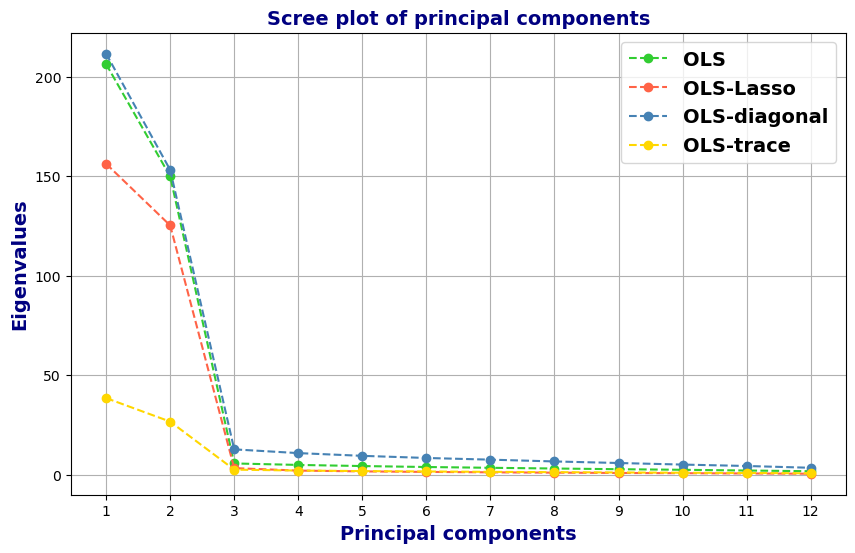

In [12]:
# Create a scree plot for the mean eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_eigenvalues_ols) + 1), mean_eigenvalues_ols, marker='o', linestyle='--',color='#32CD32' , label='OLS')
plt.plot(range(1, len(mean_eigenvalues_lasso) + 1), mean_eigenvalues_lasso, marker='o', linestyle='--',color='#FF6347', label='OLS-Lasso')
plt.plot(range(1, len(mean_eigenvalues_diag) + 1), mean_eigenvalues_diag, marker='o', linestyle='--',color='#4682B4', label='OLS-diagonal')
plt.plot(range(1, len(mean_eigenvalues_trace) + 1), mean_eigenvalues_trace, marker='o', linestyle='--', color='#FFD700', label='OLS-trace')
plt.title('Scree plot of principal components',fontsize=14, fontweight='bold', color='navy')
plt.xlabel('Principal components',fontsize=14, fontweight='bold', color='navy')
plt.ylabel('Eigenvalues',fontsize=14, fontweight='bold', color='navy')
plt.xticks(range(1, len(mean_eigenvalues_trace) + 1))
plt.legend( prop={'weight': 'bold', 'size': 14})
plt.grid()
plt.savefig('scree_plot_ensemble.pdf', bbox_inches='tight')
plt.show()

### Comments


Inspection of the plots generated, reveals that all the algorithms are capable of discerning that the initial two components exert a predominant influence on the dataset. Consequently, the objective of dimension reduction can be achieved by considering only these two dimensions, thereby establishing a dimensionality of  $d=2$. Thus, they succeed in distinguishing the number of dimensions that we expected in theory from this model.

Moreover by using right singular matrix and taking the first two columns that belong to the first and second principal component respectively, we can observe the influence that each of the $p$ features has on them. 
Results show that the linear features (0 and 2) influence more the first principal component, whereas the squared feature (1) affects more the 2nd principal component.